In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import seaborn as sn
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib.path import Path
from sklearn.metrics import classification_report, confusion_matrix

from keras.optimizers import Adam


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Data loading and preprocessing

In [2]:
from src.arrange_dataset import arrange_dataset

data_dir = arrange_dataset()     

Dataset arranged in ./data


In [3]:
from src.data_loader3D import NiiSequence, dataGenerator
from sklearn.model_selection import train_test_split

train_set, train_labels = dataGenerator(data_dir, mode="train", nb_classes=2)
test_set, test_labels = dataGenerator(data_dir, mode="val", nb_classes=2)
train_set, val_set, train_labels, val_labels = train_test_split(train_set, train_labels, test_size=0.2, random_state=42)

print("Train set size: ", len(train_set))
print("Validation set size: ", len(val_set))
print("Test set size: ", len(test_set))

batch_size = 4
nb_classes = 2
train_sequence = NiiSequence(train_set, batch_size, nb_classes=nb_classes, mode="HC")
val_sequence = NiiSequence(val_set, batch_size, nb_classes=nb_classes, mode="HC")
test_sequence = NiiSequence(test_set, batch_size, nb_classes=nb_classes, mode="HC")

print("Shape of one MRI element:", train_sequence[0][0].shape)
print("Train label example after loading:", train_sequence[0][1])

print("Shape of one batch:", test_sequence[0][0].shape)
print("Test label example after loading:", test_sequence[0][1])

Train set size:  266
Validation set size:  67
Test set size:  85
Shape of one MRI element: (4, 40, 40, 80, 1)
Train label example after loading: [[0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]
Shape of one batch: (4, 40, 40, 80, 1)
Test label example after loading: [[0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


Scan Visualization

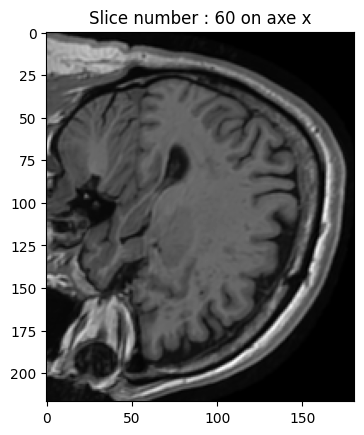

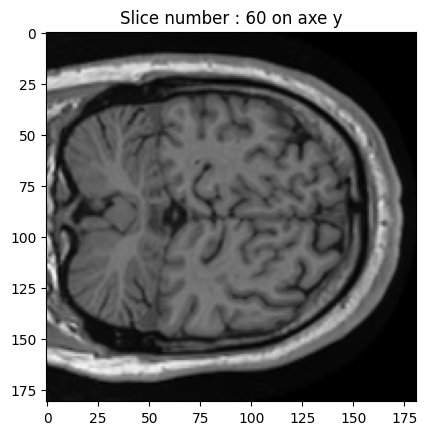

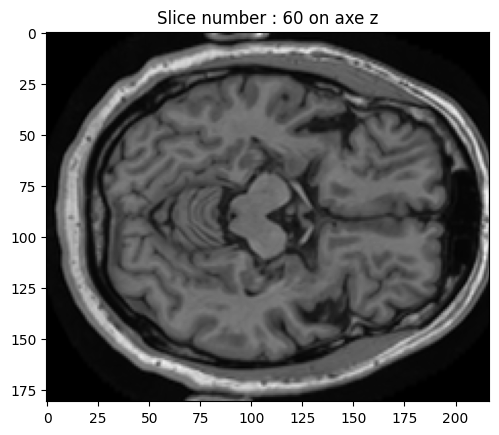

In [4]:
# MRI images are composed by many slices, build a montage of the them
def show_2D(irm, slice, axe):
    if axe == "x":
        plt.imshow(irm[slice,:,:], cmap="gray")
    elif axe == "y":
        plt.imshow(irm[:,slice,:], cmap="gray")
    elif axe == "z":
        plt.imshow(irm[:,:,slice], cmap="gray")
    plt.title("Slice number : " + str(slice) + " on axe " + axe)
    plt.show()
    
img = nib.load(train_set[0])
show_2D(img.get_fdata(), 60, "x")
show_2D(img.get_fdata(), 60, "y")
show_2D(img.get_fdata(), 60, "z")

Imbalanced Data

{'AD': 191, 'CN': 227}


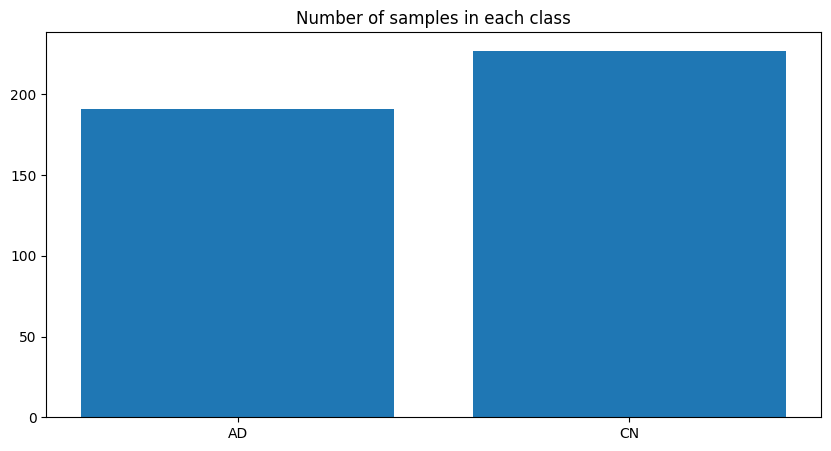

In [5]:
## Calculate number of samples in each class.
input_folder = 'lib'
class_counts = dict()
class_names = ["AD", "CN", "PMCI", "SMCI"]
if nb_classes == 2:
    class_names = ["AD", "CN"]
for folder in class_names:
    class_counts[folder] = len(os.listdir(input_folder+'/'+folder))

print(class_counts)

# plot the number of samples in each class
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Number of samples in each class')
plt.show()

3D Convolutional Neural Network

In [6]:
from src.bi_classifier3D import Biclassifier3D

input_shape = (train_sequence[0][0].shape[1], train_sequence[0][0].shape[2], train_sequence[0][0].shape[3], train_sequence[0][0].shape[4])
print("Input shape:", input_shape)
bicl = Biclassifier3D(input_shape, n_classes=nb_classes, n_filters=8, kernel_size=3, activation='relu', dropout=0.2)
model = bicl.build_model()
model.summary()
# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=2e-3),
    metrics=['accuracy'],
)

Input shape: (40, 40, 80, 1)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 40, 80, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 40, 40, 80, 8)     224       
                                                                 
 activation (Activation)     (None, 40, 40, 80, 8)     0         
                                                                 
 conv3d_1 (Conv3D)           (None, 40, 40, 80, 8)     1736      
                                                                 
 activation_1 (Activation)   (None, 40, 40, 80, 8)     0         
                                                                 
 max_pooling3d (MaxPooling3  (None, 20, 20, 40, 8)     0         
 D)                                                              
                                

Model training

In [7]:
# checkpoint
filepath="classifier3D_AD_CN_BN_D-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1)

callbacks_list = [checkpoint, early_stop, reduce_lr]

In [14]:
model.fit(
    train_sequence,
    validation_data=val_sequence,
    validation_steps=len(val_set) // batch_size,
    callbacks=callbacks_list,
    epochs=20,
)

Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 0.6947 - accuracy: 0.5338
Epoch 1: val_accuracy did not improve from 0.65625
67/67 [==============================] - 44s 658ms/step - loss: 0.6947 - accuracy: 0.5338 - val_loss: 0.6937 - val_accuracy: 0.5156 - lr: 2.0000e-05
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.7022 - accuracy: 0.5226
Epoch 2: val_accuracy did not improve from 0.65625
67/67 [==============================] - 46s 690ms/step - loss: 0.7022 - accuracy: 0.5226 - val_loss: 0.7003 - val_accuracy: 0.5156 - lr: 2.0000e-05
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.6903 - accuracy: 0.5301
Epoch 3: val_accuracy did not improve from 0.65625
67/67 [==============================] - 44s 658ms/step - loss: 0.6903 - accuracy: 0.5301 - val_loss: 0.6937 - val_accuracy: 0.5156 - lr: 2.0000e-05
Epoch 4/20
67/67 [==============================] - ETA: 0s - loss: 0.6884 - accuracy: 0.5150
Epoch 4: val_accuracy di

In [ ]:
model.fit(
    train_sequence,
    validation_data=val_sequence,
    validation_steps=len(val_set) // batch_size,
    callbacks=callbacks_list,
    epochs=20,
)

Visualizing Training History

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


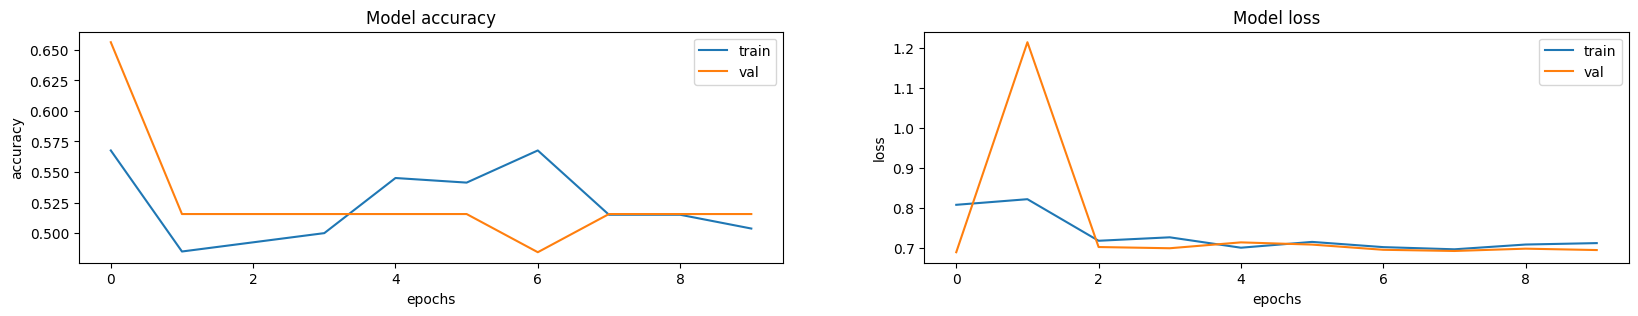

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

print(model.history.history.keys())
for i, metric in enumerate(['accuracy', 'loss']):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history[f'val_{metric}'])
    ax[i].set_title(f'Model {metric}')
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(metric)
    ax[i].legend(['train', 'val'])

Model Evaluation

In [10]:
model.evaluate(test_sequence, verbose=1)

22/22 [==============================] - 12s 525ms/step - loss: 0.6902 - accuracy: 0.5412


[0.6902350187301636, 0.5411764979362488]